> A notebook for comparing scaling methods and their affect on Support Vector Machine and Random Forest algorithms' ability to predict her2 status

I ran the following scaling methods on feature counts data:

- sklearn's preprocessing scale method
- sklearn's robust scaler method
- sklearn's quantile transform method
- BioConductor's quantile normalization method
- BioConductor's VST method

And measured each scaling method's affect on SVM and RandomForest's ability to predict her2 status given the scaled data.

For each test, I trained the algorithm on data from a selection of seven genes which are thought to pertain to the her2 pathway. I would first train on ERBB2, and then extend the training data by one gene, testing the Area Under the Receiver Operating Characteristic Curve (ROC AUC, or AUC from here on out) on each test. As an example, here is some pseudo-code:

```
Test 1

X_train, X_test = scale(gene_data[training_partition, 'ERBB2']), 
                  scale(gene_data[testing_partition, 'ERBB2'])

classifier = svm.SVC(kernel='rbf')
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

auc = roc_auc_score(y_test, predictions)



Test 2

X_train, X_test = scale(gene_data[training_partition, 'ERBB2', 'IGF1R']), 
                  scale(gene_data[testing_partition, 'ERBB2', 'IGF1R'])

classifier = svm.SVC(kernel='rbf')
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

auc = roc_auc_score(y_test, predictions)

...
```

Results are grouped by their series (i.e. ERBB2, IGF1R, FGF1, EGFR, FGFR1, IGF1, EGF). The series with the highest average AUC is the most visible on the graphs to show

1. Which series (and genes) show the greatest influence in prediction accuracy
2. How the current scaling method improves (or hurts) accuracy

>__NOTE:__ These results were previously acquired through testing in python. Each algorithm was run using 5 stratified k fold cross validation. SVM was run using the 'rbf' kernel, or 'radial basis function'

In [1]:
require(ggplot2)
require(readr)
require(reshape2)
require(scales)
require(grid)
require(plyr)

Loading required package: ggplot2
Loading required package: readr
Loading required package: reshape2
Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: grid
Loading required package: plyr


In [2]:
# I am making a function for this dinky little normalization method so I can rank the peak aucs
norm_scale <- function(x){(x - min(x)) / (max(x) - min(x))}

# First scaling method: Sklearn's preprocessing.scale method

In [3]:
# Load SVM results and find average AUC of series
svm.results = as.data.frame(read_tsv('../results/auc_scale_svm_results.tsv'))
groupings <- svm.results$grouping
svm.results$avg.val <- rowMeans(subset(svm.results, select = -grouping))
svm.results$relative.val <- rescale(svm.results$avg.val)

max(svm.results$avg.val)

svm.results$performance <- ifelse(svm.results$relative.val == 1, 
                                  svm.results$grouping, "Others")
svm.results <- melt(svm.results, 
                    id.vars = c('grouping', 'avg.val', 
                                'performance', 'relative.val'), 
                    variable.name = 'series')

# Load RandomForest results and find average AUC of series
rf.results = as.data.frame(read_tsv('../results/auc_scale_rf_results.tsv'))
groupings <- rf.results$grouping
rf.results$avg.val <- rowMeans(subset(rf.results, select = -grouping))
rf.results$relative.val <- rescale(rf.results$avg.val)

max(rf.results$avg.val)

rf.results$performance <- ifelse(rf.results$relative.val == 1, 
                                 rf.results$grouping, "Others")
rf.results <- melt(rf.results, 
                   id.vars = c('grouping', 'avg.val', 
                               'performance', 'relative.val'), 
                   variable.name = 'series')

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7397582

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7501834

In [4]:
# Construct line plots
#     RF/rf = Random Forest
gsvm <- ggplot(data = svm.results, aes(x = series, y = value, 
                                       group = grouping, 
                                       alpha = performance, 
                                       linetype = performance))

ggsvm <- gsvm + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "SVM Scale", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(svm.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15, # Put it outside of graph
            ymin = round(max(svm.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(svm.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(svm.results$value), digits = 2) - 
                    ((round(max(svm.results$value), digits = 2) - 
                      round(min(svm.results$value), digits = 2)) / 6))
            )

grf <- ggplot(data = rf.results, aes(x = series, y = value, 
                                     group = grouping, 
                                     alpha = performance, 
                                     linetype = performance))

ggrf <- grf + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "RF Scale", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(rf.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(rf.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(rf.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(rf.results$value), digits = 2) - 
                    ((round(max(rf.results$value), digits = 2) - 
                      round(min(rf.results$value), digits = 2)) / 6))
            )

This standard scale method does not account for outliers and just places each data point within a relative scale between -1 and 1

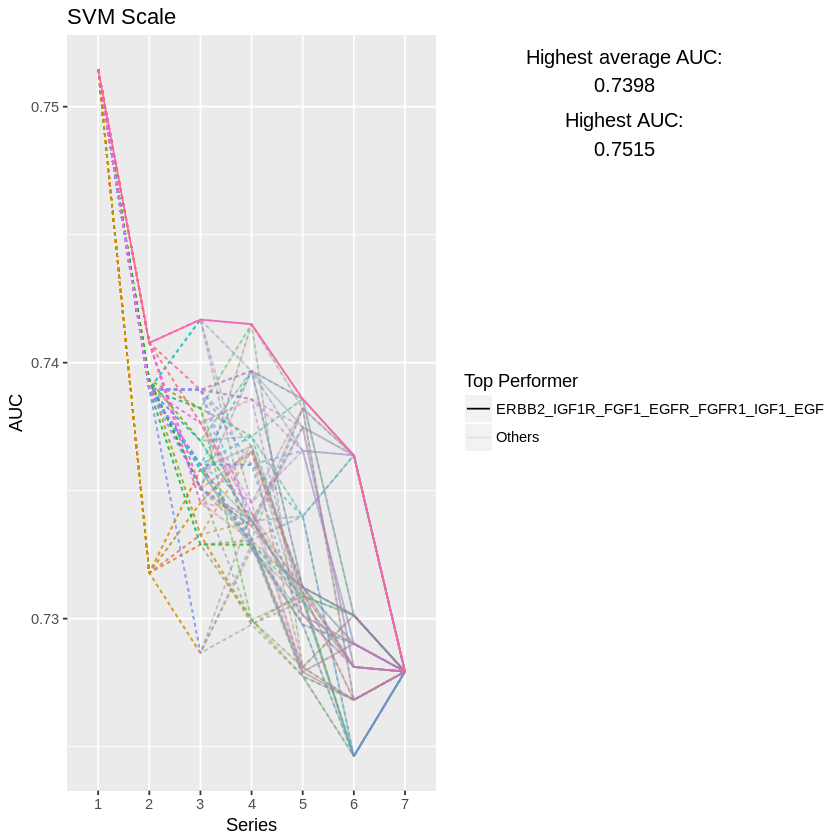

In [5]:
# Draw both graphs, but make sure annotations are intact 
#  (if I do not use the gtable, the annotations will be clipped)
gt <- ggplot_gtable(ggplot_build(ggsvm))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

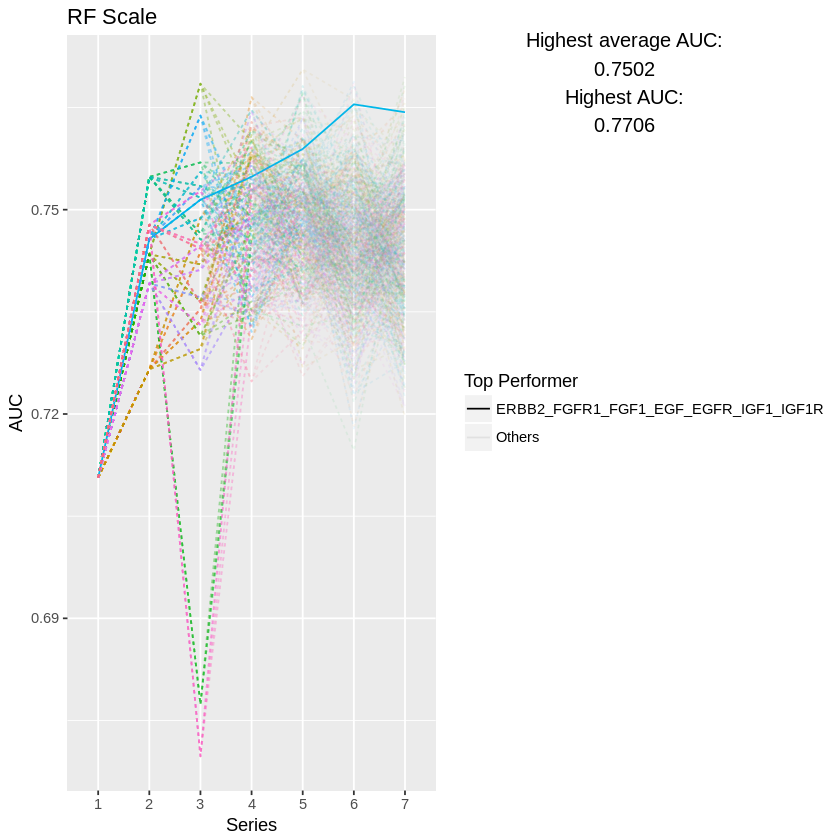

In [6]:
gt <- ggplot_gtable(ggplot_build(ggrf))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

>__EDIT JULY 3, 2018:__ I will compare the peak performances of each grouping

series,value,genes,relative
1,0.751457,ERBB2,NaN


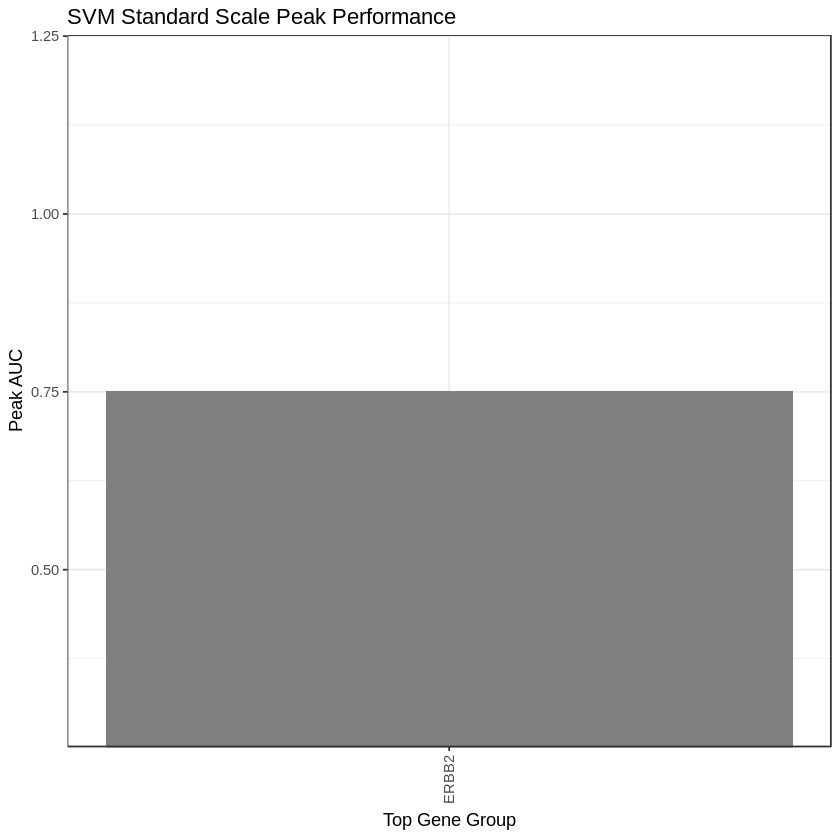

In [7]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- svm.results[which(svm.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "SVM Standard Scale Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

#ggsave('peak_performance[error].pdf', gghist, device = 'pdf')

At first I was a little shocked by the above results, but then I remembered that SVM performs worse after the initial ERBB2 testing every time with the standard scaling method

,series,value,genes,relative
3601,6,0.7585705,"ERBB2, FGFR1, EGFR, IGF1R, FGF1, EGF",0.6174016
2882,5,0.7492445,"ERBB2, FGFR1, EGFR, IGF1R, FGF1",0.3205225
3603,6,0.7598906,"ERBB2, FGFR1, EGFR, IGF1R, EGF, FGF1",0.6594239
1444,3,0.7487655,"ERBB2, FGFR1, EGFR",0.3052725
4325,7,0.7537219,"ERBB2, FGFR1, EGFR, IGF1R, IGF1, FGF1, EGF",0.4630532
2887,5,0.7594333,"ERBB2, FGFR1, EGFR, FGF1, IGF1R",0.6448674


Saving 30 x 6.67 in image


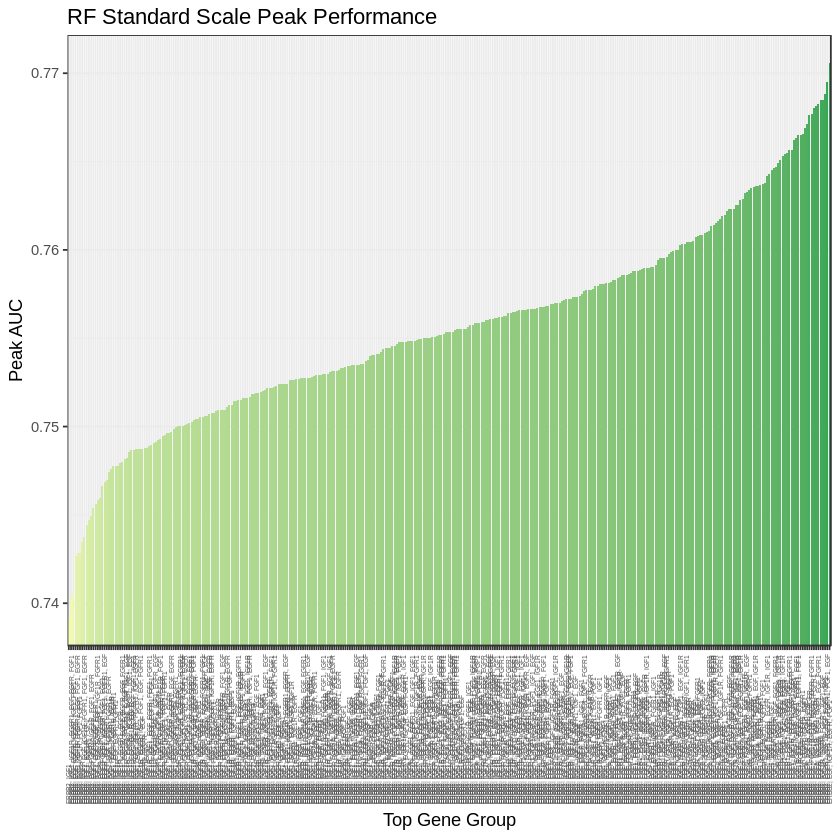

In [8]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- rf.results[which(rf.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "RF Standard Scale Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, size = 4, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

ggsave('peak_performance_scale.pdf', gghist, device = 'pdf', width = 30)

Since the gene groups are illegible on the graph, I will be providing downloadable pdfs after each analysis. These pdfs are much wider and high enough quality that the reader can zoom in and read the gene groups found on the x axis.

Download [here](https://github.com/zence/SCCR/raw/Kumiko/notebooks/peak_performance_scale.pdf)

## SVM

As you can see, SVM performs best with less data. From what I've read, SVM works best when provided with only the most pertinent data. Since ERBB2 has the greatest correlation to HER2 positivity, other genes only make the data noisier. It might be useful to run tests where ERBB2 is not the first gene provided/the only gene that ever stands alone. This could potentially show ERBB2's influence, although we will not see an improvement in AUC beyond the performance of just ERBB2.

## Random Forest

RF performs better with more variables, although there surely must be limit and noisy data will always cause issues. For this reason, the top performer takes a slight decline when IGF1R is added to the data. Since the lines do not converge like they do at the end of the SVM graph, we can infer that the order in which features are presented to the algorithm can affect the overall performance. We also see that some genes cause for of an issue than others. The next bit of code will reveal which gene caused the significant AUC drop that we see on the third series.

In [9]:
rf.results$grouping[which(rf.results$value == min(rf.results$value))]

[1] "ERBB2_IGF1R_EGFR_FGFR1_FGF1_EGF_IGF1"
 [2] "ERBB2_IGF1R_EGFR_FGFR1_FGF1_IGF1_EGF"
 [3] "ERBB2_IGF1R_EGFR_FGFR1_EGF_FGF1_IGF1"
 [4] "ERBB2_IGF1R_EGFR_FGFR1_EGF_IGF1_FGF1"
 [5] "ERBB2_IGF1R_EGFR_FGFR1_IGF1_FGF1_EGF"
 [6] "ERBB2_IGF1R_EGFR_FGFR1_IGF1_EGF_FGF1"
 [7] "ERBB2_IGF1R_EGFR_FGF1_FGFR1_EGF_IGF1"
 [8] "ERBB2_IGF1R_EGFR_FGF1_FGFR1_IGF1_EGF"
 [9] "ERBB2_IGF1R_EGFR_FGF1_EGF_FGFR1_IGF1"
[10] "ERBB2_IGF1R_EGFR_FGF1_EGF_IGF1_FGFR1"
[11] "ERBB2_IGF1R_EGFR_FGF1_IGF1_FGFR1_EGF"
[12] "ERBB2_IGF1R_EGFR_FGF1_IGF1_EGF_FGFR1"
[13] "ERBB2_IGF1R_EGFR_EGF_FGFR1_FGF1_IGF1"
[14] "ERBB2_IGF1R_EGFR_EGF_FGFR1_IGF1_FGF1"
[15] "ERBB2_IGF1R_EGFR_EGF_FGF1_FGFR1_IGF1"
[16] "ERBB2_IGF1R_EGFR_EGF_FGF1_IGF1_FGFR1"
[17] "ERBB2_IGF1R_EGFR_EGF_IGF1_FGFR1_FGF1"
[18] "ERBB2_IGF1R_EGFR_EGF_IGF1_FGF1_FGFR1"
[19] "ERBB2_IGF1R_EGFR_IGF1_FGFR1_FGF1_EGF"
[20] "ERBB2_IGF1R_EGFR_IGF1_FGFR1_EGF_FGF1"
[21] "ERBB2_IGF1R_EGFR_IGF1_FGF1_FGFR1_EGF"
[22] "ERBB2_IGF1R_EGFR_IGF1_FGF1_EGF_FGFR1"
[23] "ERBB2_IGF1R_EGFR_IGF1_EGF_FGFR1_FGF1"
[24] "ERBB2_IGF1R_EGFR_IGF1_EGF_FGF1_FGFR1"


As we can see, there are multiple groupings, but they all share the first three genes: ERBB2, IGF1R, and then EGFR

For whatever reason, EGFR is the worst possible option for the third gene slot. This also shows us that adding a third feature to Random Forest can cause a significant divide where other positions in the series are not as crucial.

Now, I'll look at which order created our peak:

In [10]:
rf.results$grouping[which(rf.results$value == max(rf.results$value))]

[1] "ERBB2_EGF_IGF1R_EGFR_FGF1_FGFR1_IGF1"
[2] "ERBB2_EGF_IGF1R_EGFR_FGF1_IGF1_FGFR1"

There are only two groupings that show this peak, which is nearly invisible.

>__NOTE:__ I have the alpha set low so the grouping with the highest average AUC sticks out, and this is the highest alpha that I feel comfortable with, since it still makes the one line stick out without making the lines entirely invisible

From here on out, I will mostly only speak about the influence of scaling methods on the algorithms and not the ordering of gene data, although there may be different gene groupings that prove to be the most useful within these next few tests

# Second scaling method: sklearn's RobustScaler method

In [11]:
# Load SVM results and find average AUC of series
svm.results = as.data.frame(read_tsv('../results/auc_robust_svm_results.tsv'))
groupings <- svm.results$grouping
svm.results$avg.val <- rowMeans(subset(svm.results, select = -grouping))
svm.results$relative.val <- rescale(svm.results$avg.val)

max(svm.results$avg.val)

svm.results$performance <- ifelse(svm.results$relative.val == 1, 
                                  svm.results$grouping, "Others")
svm.results <- melt(svm.results, 
                    id.vars = c('grouping', 'avg.val', 
                                'performance', 'relative.val'), 
                    variable.name = 'series')

# Load RandomForest results and find average AUC of series
rf.results = as.data.frame(read_tsv('../results/auc_robust_rf_results.tsv'))
groupings <- rf.results$grouping
rf.results$avg.val <- rowMeans(subset(rf.results, select = -grouping))
rf.results$relative.val <- rescale(rf.results$avg.val)

max(rf.results$avg.val)

rf.results$performance <- ifelse(rf.results$relative.val == 1, 
                                 rf.results$grouping, "Others")
rf.results <- melt(rf.results, 
                   id.vars = c('grouping', 'avg.val', 
                               'performance', 'relative.val'), 
                   variable.name = 'series')

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7455463

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7579137

In [12]:
# Construct line plots
#     RF/rf = Random Forest
gsvm <- ggplot(data = svm.results, aes(x = series, y = value, 
                                       group = grouping, 
                                       alpha = performance, 
                                       linetype = performance))

ggsvm <- gsvm + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "SVM Robust Scale", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(svm.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(svm.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(svm.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(svm.results$value), digits = 2) - 
                    ((round(max(svm.results$value), digits = 2) - 
                      round(min(svm.results$value), digits = 2)) / 6))
            )

grf <- ggplot(data = rf.results, aes(x = series, y = value, 
                                     group = grouping, 
                                     alpha = performance, 
                                     linetype = performance))

ggrf <- grf + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "RF Robust Scale", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(rf.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(rf.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(rf.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(rf.results$value), digits = 2) - 
                    ((round(max(rf.results$value), digits = 2) - 
                      round(min(rf.results$value), digits = 2)) / 6))
            )

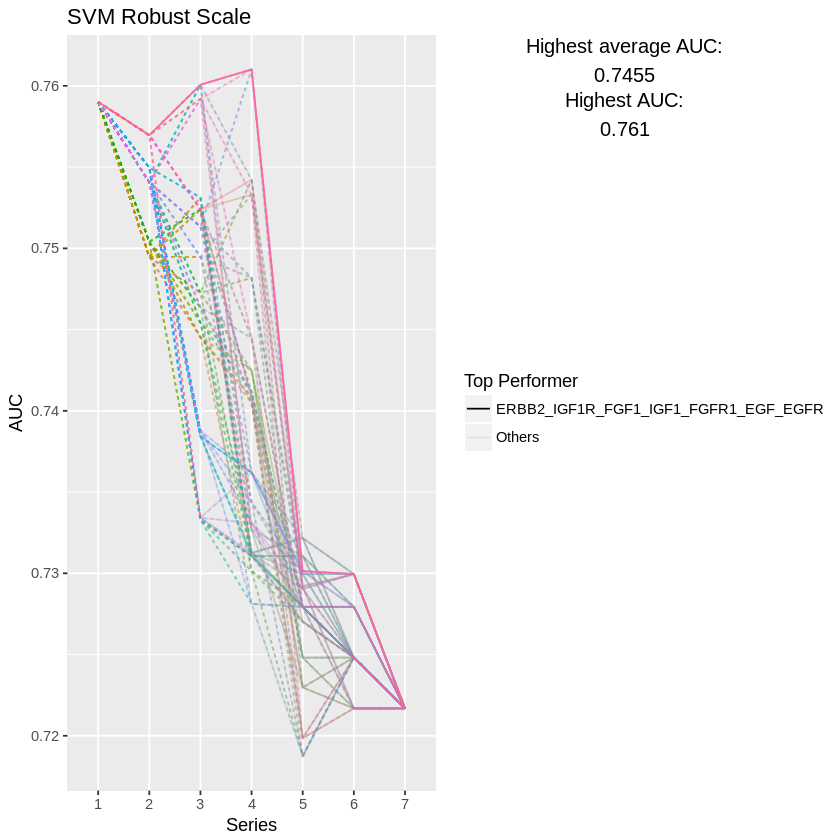

In [13]:
gt <- ggplot_gtable(ggplot_build(ggsvm))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

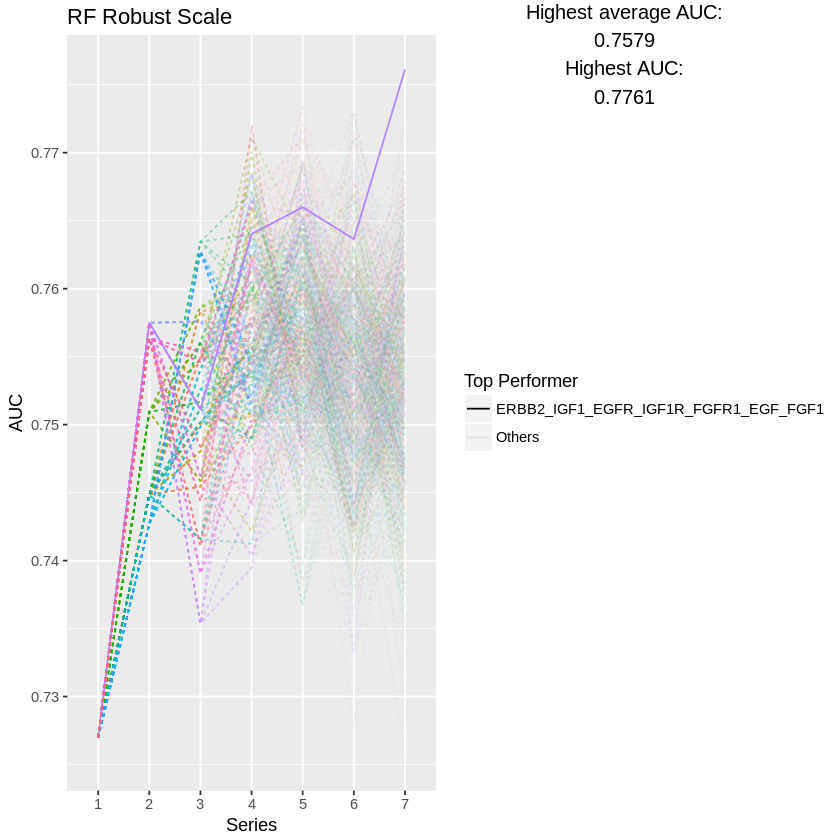

In [14]:
gt <- ggplot_gtable(ggplot_build(ggrf))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

,series,value,genes,relative
1,1,0.7590138,ERBB2,0.00000000
1729,3,0.7600694,"ERBB2, IGF1R, FGF1",0.52824579
2467,4,0.7610122,"ERBB2, IGF1R, FGF1, IGF1",1.00000000
1777,3,0.7591940,"ERBB2, IGF1R, IGF1",0.09018831
2509,4,0.7610122,"ERBB2, IGF1R, IGF1, FGF1",1.00000000
1849,3,0.7600694,"ERBB2, FGF1, IGF1R",0.52824579


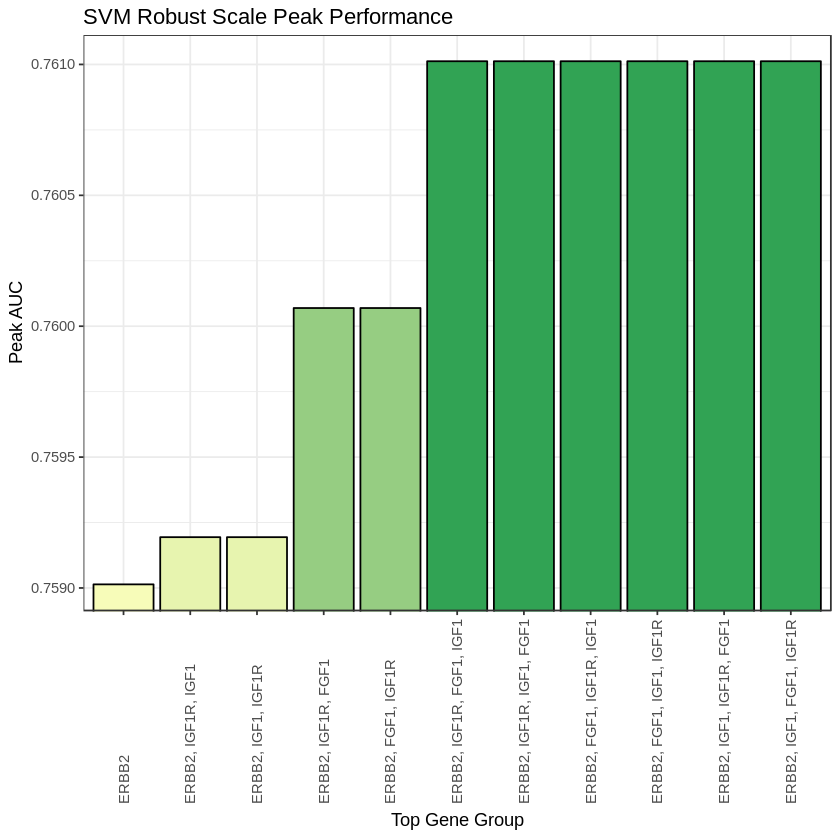

In [15]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- svm.results[which(svm.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative, color = 'black'))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "SVM Robust Scale Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F, color = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  scale_color_manual(values = 'black') +
                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

#ggsave('peak_performance[error].pdf', gghist, device = 'pdf')

At first I was a little shocked by the above results, but then I remembered that SVM performs worse after the initial ERBB2 testing every time with the standard scaling method

,series,value,genes,relative
2881,5,0.7538560,"ERBB2, FGFR1, EGFR, IGF1R, FGF1",0.1760818
3602,6,0.7601565,"ERBB2, FGFR1, EGFR, IGF1R, FGF1, IGF1",0.4091815
2883,5,0.7669178,"ERBB2, FGFR1, EGFR, IGF1R, EGF",0.6593314
4325,7,0.7614268,"ERBB2, FGFR1, EGFR, IGF1R, IGF1, FGF1, EGF",0.4561788
2886,5,0.7603872,"ERBB2, FGFR1, EGFR, IGF1R, IGF1",0.4177181
2887,5,0.7650491,"ERBB2, FGFR1, EGFR, FGF1, IGF1R",0.5901957


Saving 30 x 6.67 in image


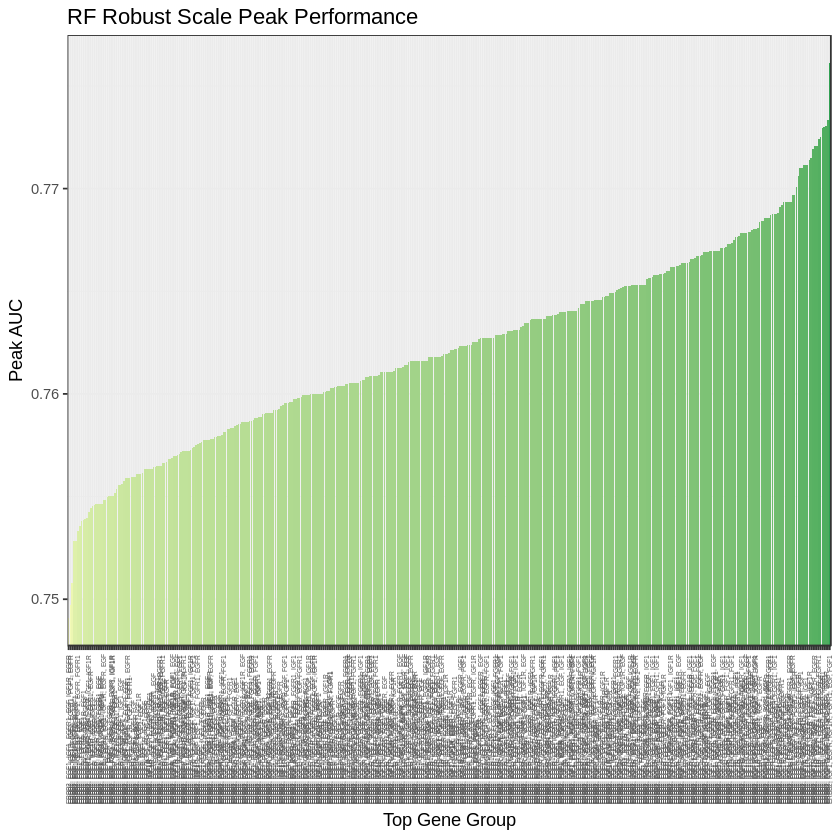

In [16]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- rf.results[which(rf.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "RF Robust Scale Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, size = 4, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

ggsave('peak_performance_robust.pdf', gghist, device = 'pdf', width = 30)

>__DOWNLOAD:__ [here](https://github.com/zence/SCCR/raw/Kumiko/notebooks/peak_performance_robust.pdf)

It is already apparent that robust scaler, which accounts more for outliers, improves overall performance in both algorithms.

## SVM

Unlike in the standard scaling method, we see that robust scaler causes SVM to actually improve when given more data. From this we can learn that some genes will be more useful when properly scaled. This positive trend is lost after the fourth series, seeing that all of the tests declined in AUC on the fifth series and so on.

## RF

We see that most of the groupings actually performed their worst when only given ERBB2 data. It looks to me like there is a single line that dips fairly low in the seventh series, so I'm going to check to see how many groupings belong to the lowest AUC.

In [17]:
rf.results$grouping[which(rf.results$value == min(rf.results$value))]

[1] "ERBB2_FGF1_EGF_EGFR_FGFR1_IGF1R_IGF1"

As I suspected, the single line that dips on the seventh series dips farther than its initial starting point. This performance is still better than the lowest AUC of the standard scale method on RandomForest. I will now look at all of the data of this particular grouping.

In [18]:
unique(rf.results$grouping[which(rf.results$grouping == 
                                 'ERBB2_FGF1_EGF_EGFR_FGFR1_IGF1R_IGF1')])
rf.results[which(rf.results$grouping == 'ERBB2_FGF1_EGF_EGFR_FGFR1_IGF1R_IGF1'),
          c('series', 'avg.val', 'relative.val', 'value')]

[1] "ERBB2_FGF1_EGF_EGFR_FGFR1_IGF1R_IGF1"

,series,avg.val,relative.val,value
439,1,0.7469274,0.3100075,0.7269921
1159,2,0.7469274,0.3100075,0.7448156
1879,3,0.7469274,0.3100075,0.7561392
2599,4,0.7469274,0.3100075,0.7645546
3319,5,0.7469274,0.3100075,0.7608649
4039,6,0.7469274,0.3100075,0.7495083
4759,7,0.7469274,0.3100075,0.7256173


It doesn't even have the lowest performance! Out of curiosity, I will now check the data points of the grouping with the lowest average AUC. This won't really add much to this analysis, but dang it if I don't find that intriguing.

In [19]:
unique(rf.results$grouping[which(rf.results$relative.val == 0)])
rf.results[which(rf.results$relative.val == 0),
          c('series', 'avg.val', 'relative.val', 'value')]

[1] "ERBB2_FGF1_IGF1_FGFR1_EGF_IGF1R_EGFR"

,series,avg.val,relative.val,value
462,1,0.7419914,0,0.7269921
1182,2,0.7419914,0,0.7448156
1902,3,0.7419914,0,0.7415867
2622,4,0.7419914,0,0.7412423
3342,5,0.7419914,0,0.7438399
4062,6,0.7419914,0,0.7463665
4782,7,0.7419914,0,0.7490966


I don't really have anything to say about this. We all know how averages and numbers work.

# Third scaling method: sklearn's Quantile Transform method

In [20]:
# Load SVM results and find average AUC of series
svm.results = as.data.frame(read_tsv('../results/auc_quantile_svm_results.tsv'))
groupings <- svm.results$grouping
svm.results$avg.val <- rowMeans(subset(svm.results, select = -grouping))
svm.results$relative.val <- rescale(svm.results$avg.val)

max(svm.results$avg.val)

svm.results$performance <- ifelse(svm.results$relative.val == 1, 
                                  svm.results$grouping, "Others")
svm.results <- melt(svm.results, 
                    id.vars = c('grouping', 'avg.val', 
                                'performance', 'relative.val'), 
                    variable.name = 'series')

# Load RandomForest results and find average AUC of series
rf.results = as.data.frame(read_tsv('../results/auc_quantile_rf_results.tsv'))
groupings <- rf.results$grouping
rf.results$avg.val <- rowMeans(subset(rf.results, select = -grouping))
rf.results$relative.val <- rescale(rf.results$avg.val)

max(rf.results$avg.val)

rf.results$performance <- ifelse(rf.results$relative.val == 1, 
                                 rf.results$grouping, "Others")
rf.results <- melt(rf.results, 
                   id.vars = c('grouping', 'avg.val', 
                               'performance', 'relative.val'), 
                   variable.name = 'series')

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7187028

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7418426

In [21]:
# Construct line plots
#     RF/rf = Random Forest
gsvm <- ggplot(data = svm.results, aes(x = series, y = value, 
                                       group = grouping, 
                                       alpha = performance, 
                                       linetype = performance))

ggsvm <- gsvm + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "SVM Quantile Transform", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(svm.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(svm.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(svm.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(svm.results$value), digits = 2) - 
                    ((round(max(svm.results$value), digits = 2) - 
                      round(min(svm.results$value), digits = 2)) / 6))
            )

grf <- ggplot(data = rf.results, aes(x = series, y = value, 
                                     group = grouping, 
                                     alpha = performance, 
                                     linetype = performance))

ggrf <- grf + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "RF Quantile Transform", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(rf.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(rf.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(rf.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(rf.results$value), digits = 2) - 
                    ((round(max(rf.results$value), digits = 2) - 
                      round(min(rf.results$value), digits = 2)) / 6))
            )

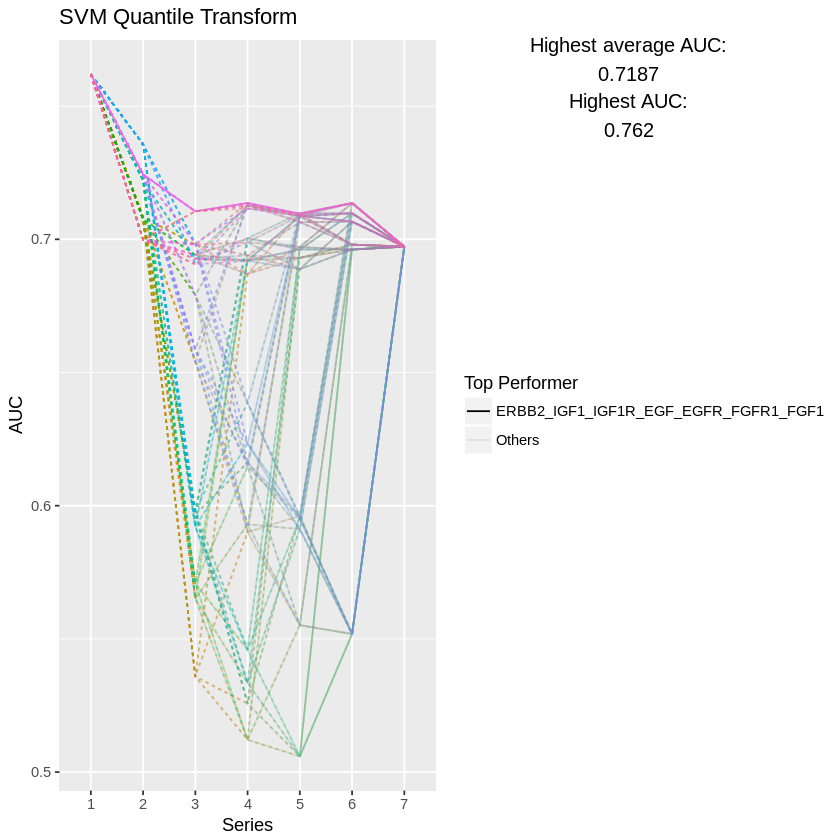

In [22]:
gt <- ggplot_gtable(ggplot_build(ggsvm))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

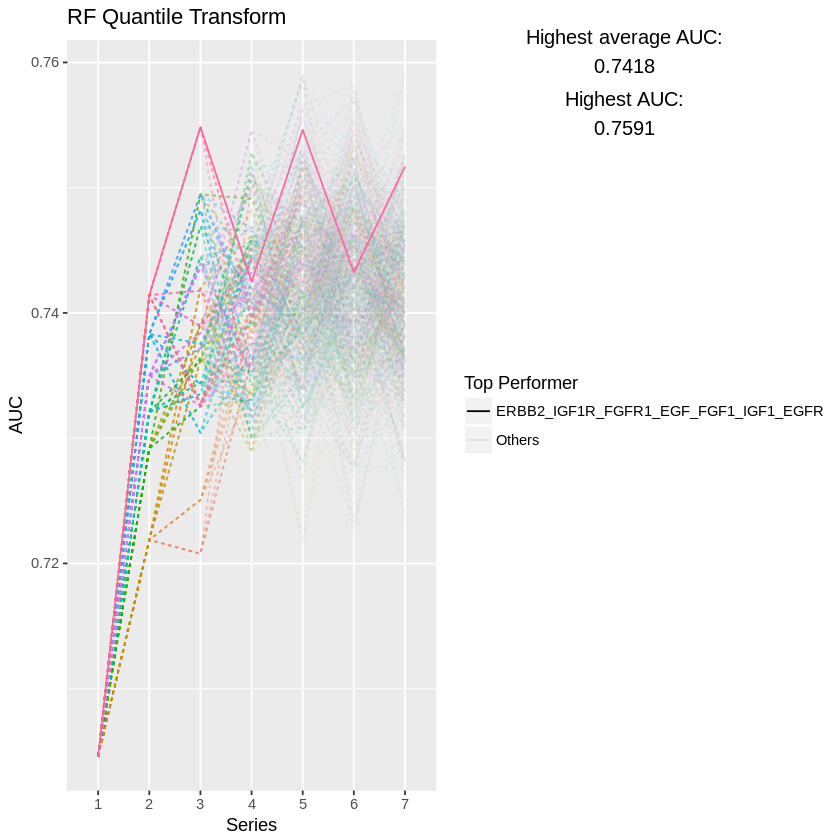

In [23]:
gt <- ggplot_gtable(ggplot_build(ggrf))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

series,value,genes,relative
1,0.7619872,ERBB2,NaN


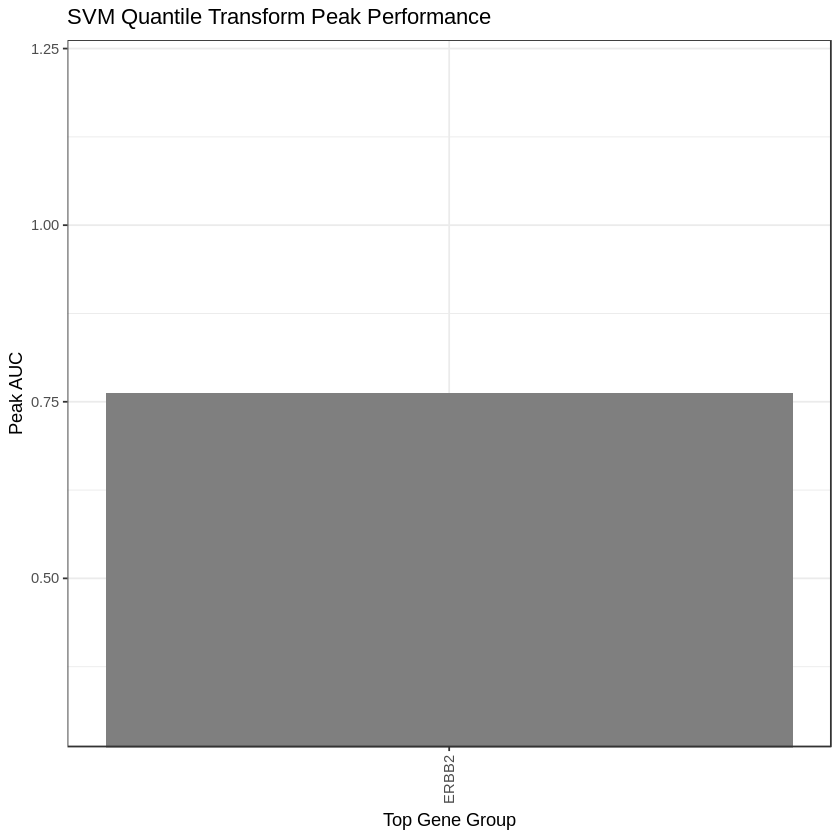

In [24]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- svm.results[which(svm.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "SVM Quantile Transform Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

#ggsave('peak_performance[error].pdf', gghist, device = 'pdf')

At first I was a little shocked by the above results, but then I remembered that SVM performs worse after the initial ERBB2 testing every time with the standard scaling method

,series,value,genes,relative
2161,4,0.7445476,"ERBB2, FGFR1, EGFR, IGF1R",0.3647447
2883,5,0.7588622,"ERBB2, FGFR1, EGFR, IGF1R, EGF",0.9913411
2885,5,0.7506306,"ERBB2, FGFR1, EGFR, IGF1R, IGF1",0.6310180
3607,6,0.7500358,"ERBB2, FGFR1, EGFR, FGF1, IGF1R, EGF",0.6049818
2888,5,0.7454398,"ERBB2, FGFR1, EGFR, FGF1, IGF1R",0.4038017
3609,6,0.7491098,"ERBB2, FGFR1, EGFR, FGF1, EGF, IGF1R",0.5644510


Saving 30 x 6.67 in image


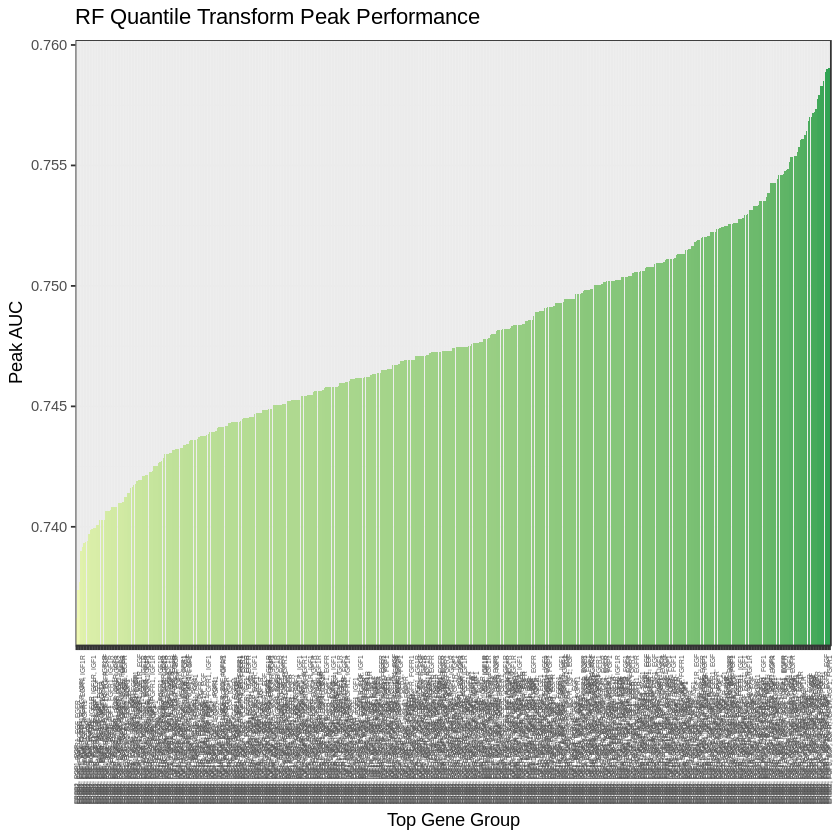

In [25]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- rf.results[which(rf.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "RF Quantile Transform Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, size = 4, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

ggsave('peak_performance_quan_tran.pdf', gghist, device = 'pdf', width = 30)

>__DOWNLOAD:__ [here](https://github.com/zence/SCCR/raw/Kumiko/notebooks/peak_performance_quan_tran.pdf)

Quantile transform did not really help either algorithm and, at least, in this moment, is not worth my time to analyze.

# Fourth scaling method: BioConductor's Quantile Normalization method

In [26]:
# Load SVM results and find average AUC of series
svm.results = as.data.frame(read_tsv('../results/auc_norm_quan_svm_results.tsv'))
groupings <- svm.results$grouping
svm.results$avg.val <- rowMeans(subset(svm.results, select = -grouping))
svm.results$relative.val <- rescale(svm.results$avg.val)

max(svm.results$avg.val)

svm.results$performance <- ifelse(svm.results$relative.val == 1, 
                                  svm.results$grouping, "Others")
svm.results <- melt(svm.results, 
                    id.vars = c('grouping', 'avg.val', 
                                'performance', 'relative.val'), 
                    variable.name = 'series')

# Load RandomForest results and find average AUC of series
rf.results = as.data.frame(read_tsv('../results/auc_norm_quan_rf_results.tsv'))
groupings <- rf.results$grouping
rf.results$avg.val <- rowMeans(subset(rf.results, select = -grouping))
rf.results$relative.val <- rescale(rf.results$avg.val)

max(rf.results$avg.val)

rf.results$performance <- ifelse(rf.results$relative.val == 1, 
                                 rf.results$grouping, "Others")
rf.results <- melt(rf.results, 
                   id.vars = c('grouping', 'avg.val', 
                               'performance', 'relative.val'), 
                   variable.name = 'series')

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.5304451

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7609473

In [27]:
# Construct line plots
#     RF/rf = Random Forest
gsvm <- ggplot(data = svm.results, aes(x = series, y = value, 
                                       group = grouping, 
                                       alpha = performance, 
                                       linetype = performance))

ggsvm <- gsvm + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "SVM Normalized Quantile", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(svm.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15, 
            ymin = round(max(svm.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(svm.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(svm.results$value), digits = 2) - 
                    ((round(max(svm.results$value), digits = 2) - 
                      round(min(svm.results$value), digits = 2)) / 6))
            )

grf <- ggplot(data = rf.results, aes(x = series, y = value, 
                                     group = grouping, 
                                     alpha = performance, 
                                     linetype = performance))

ggrf <- grf + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "RF Normalized Quantile", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(rf.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(rf.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(rf.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(rf.results$value), digits = 2) - 
                    ((round(max(rf.results$value), digits = 2) - 
                      round(min(rf.results$value), digits = 2)) / 6))
            )

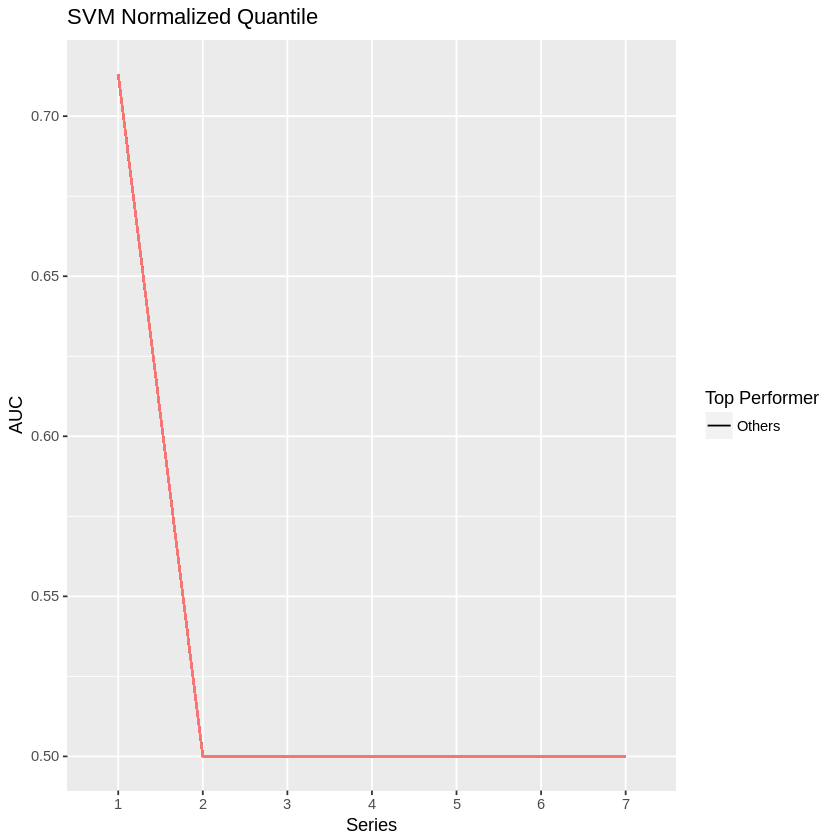

In [28]:
gt <- ggplot_gtable(ggplot_build(ggsvm))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

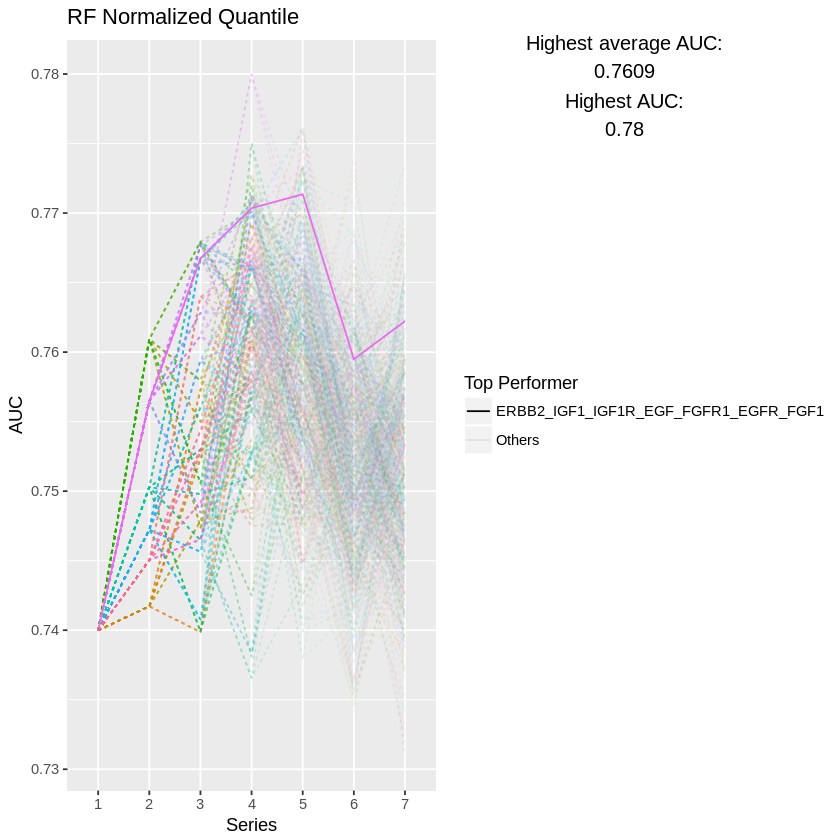

In [29]:
gt <- ggplot_gtable(ggplot_build(ggrf))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

series,value,genes,relative
1,0.7131158,ERBB2,NaN


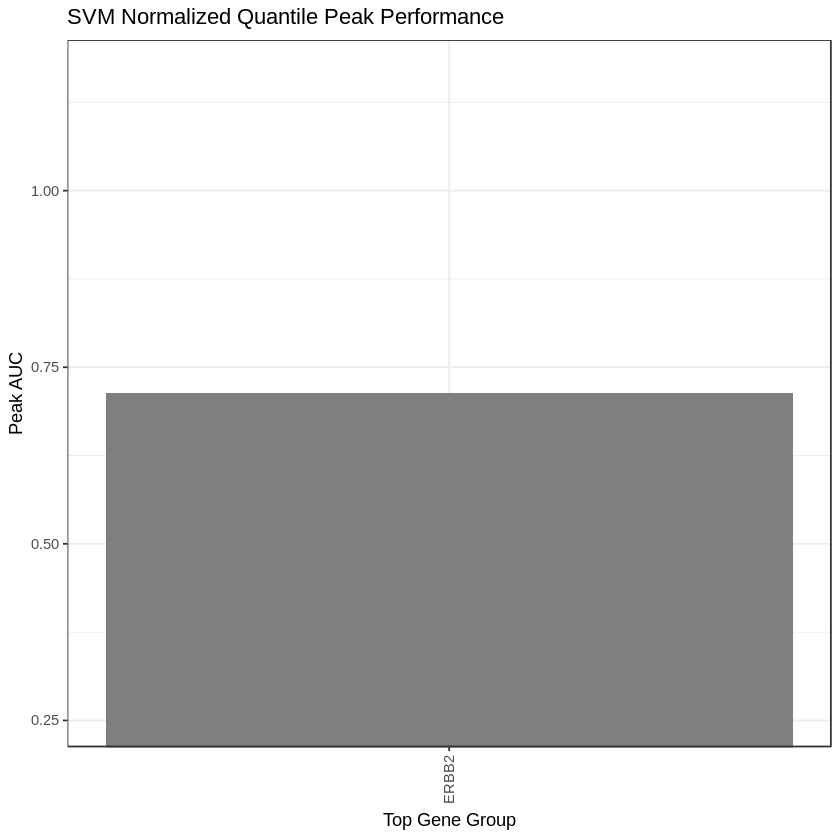

In [30]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- svm.results[which(svm.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "SVM Normalized Quantile Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

#ggsave('peak_performance_norm_quan.pdf', gghist, device = 'pdf')

At first I was a little shocked by the above results, but then I remembered that SVM performs worse after the initial ERBB2 testing every time with the standard scaling method

,series,value,genes,relative
3601,6,0.7646325,"ERBB2, FGFR1, EGFR, IGF1R, FGF1, EGF",0.4679626
4322,7,0.7683196,"ERBB2, FGFR1, EGFR, IGF1R, FGF1, IGF1, EGF",0.5957147
2883,5,0.7656530,"ERBB2, FGFR1, EGFR, IGF1R, EGF",0.5033202
2165,4,0.7634537,"ERBB2, FGFR1, EGFR, IGF1R",0.4271205
2887,5,0.7583908,"ERBB2, FGFR1, EGFR, FGF1, IGF1R",0.2516992
3608,6,0.7586749,"ERBB2, FGFR1, EGFR, FGF1, IGF1R, IGF1",0.2615425


Saving 30 x 6.67 in image


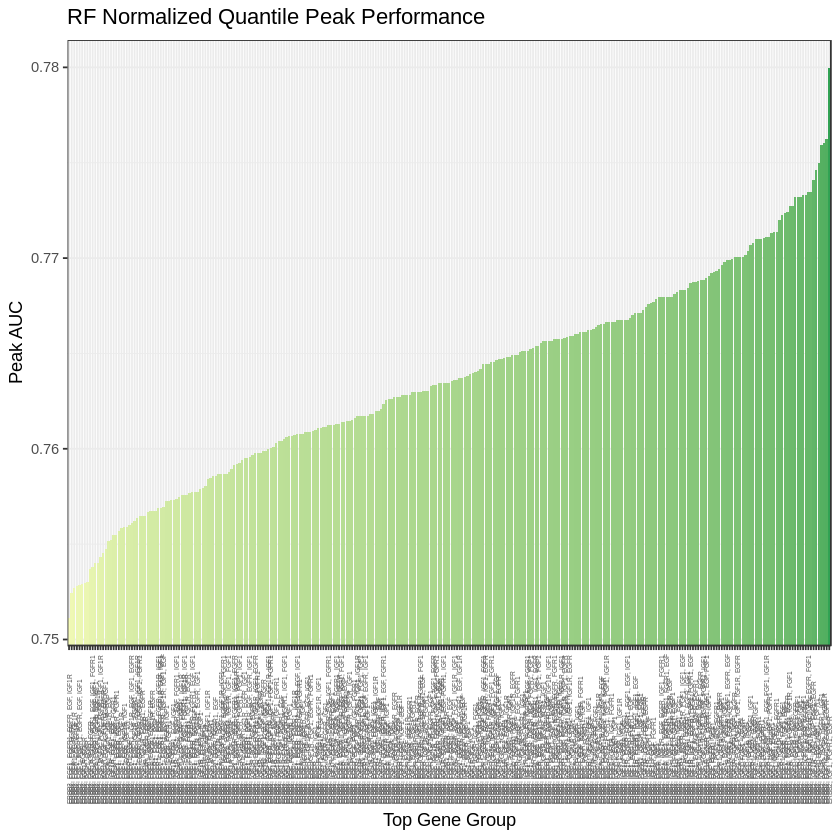

In [31]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- rf.results[which(rf.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "RF Normalized Quantile Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, size = 4, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

ggsave('peak_performance_norm_quan.pdf', gghist, device = 'pdf', width = 30)

>__DOWNLOAD:__ [here](https://github.com/zence/SCCR/raw/Kumiko/notebooks/peak_performance_norm_quan.pdf)

We see that quantile normalization improved the RF's highest average AUC as well as its highest AUC peak (0.78). However, it proved detrimental to SVM.

I'm going to print off the data of the groupings that were part of the highest peak and the lowest low. I will not analyze the data at this time, seeing as this has gotten really long.

>Highest peak

In [32]:
rf.results[which(rf.results$value == max(rf.results$value)), 
           c('grouping', 'avg.val', 'relative.val', 'value')]

,grouping,avg.val,relative.val,value
2761,ERBB2_IGF1_FGFR1_EGFR_IGF1R_FGF1_EGF,0.7589568,0.8800763,0.7799878
2762,ERBB2_IGF1_FGFR1_EGFR_IGF1R_EGF_FGF1,0.7592106,0.8953665,0.7799878
2763,ERBB2_IGF1_FGFR1_EGFR_FGF1_IGF1R_EGF,0.7596732,0.9232353,0.7799878
2764,ERBB2_IGF1_FGFR1_EGFR_FGF1_EGF_IGF1R,0.7598587,0.9344113,0.7799878
2765,ERBB2_IGF1_FGFR1_EGFR_EGF_IGF1R_FGF1,0.7589003,0.8766725,0.7799878
2766,ERBB2_IGF1_FGFR1_EGFR_EGF_FGF1_IGF1R,0.7594778,0.9114656,0.7799878


>Lowest low

In [33]:
rf.results[which(rf.results$value == min(rf.results$value)),
          c('grouping', 'avg.val', 'relative.val', 'series', 'value')]

,grouping,avg.val,relative.val,series,value
4816,ERBB2_EGF_FGFR1_FGF1_IGF1R_IGF1_EGFR,0.7494177,0.3053583,7,0.7309226


> It should be noted that I accidentally began to run SVM with quantile normalization and standard scaling and it actually performed decently, but I interrupted the program before it could finish and do not have that data. I may go back and see how well SVM and RF perform with a combination of scaling methods (especially the most different ones)

# Fifth scaling method: BioConductor's VST method

In [34]:
# Load SVM results and find average AUC of series
svm.results = as.data.frame(read_tsv('../results/auc_vsd_svm_results.tsv'))
groupings <- svm.results$grouping
svm.results$avg.val <- rowMeans(subset(svm.results, select = -grouping))
svm.results$relative.val <- rescale(svm.results$avg.val)

max(svm.results$avg.val)

svm.results$performance <- ifelse(svm.results$relative.val == 1, 
                                  svm.results$grouping, "Others")
svm.results <- melt(svm.results, 
                    id.vars = c('grouping', 'avg.val', 
                                'performance', 'relative.val'), 
                    variable.name = 'series')

# Load RandomForest results and find average AUC of series
rf.results = as.data.frame(read_tsv('../results/auc_vsd_rf_results.tsv'))
groupings <- rf.results$grouping
rf.results$avg.val <- rowMeans(subset(rf.results, select = -grouping))
rf.results$relative.val <- rescale(rf.results$avg.val)

max(rf.results$avg.val)

rf.results$performance <- ifelse(rf.results$relative.val == 1, 
                                 rf.results$grouping, "Others")
rf.results <- melt(rf.results, 
                   id.vars = c('grouping', 'avg.val', 
                               'performance', 'relative.val'), 
                   variable.name = 'series')

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.5304451

Parsed with column specification:
cols(
  grouping = col_character(),
  `1` = col_double(),
  `2` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double()
)


[1] 0.7552957

In [35]:
# Construct line plots
#     RF/rf = Random Forest
gsvm <- ggplot(data = svm.results, aes(x = series, y = value, 
                                       group = grouping, 
                                       alpha = performance, 
                                       linetype = performance))

ggsvm <- gsvm + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "SVM VST", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(svm.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(svm.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(svm.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(svm.results$value), digits = 2) - 
                    ((round(max(svm.results$value), digits = 2) - 
                      round(min(svm.results$value), digits = 2)) / 6))
            )

grf <- ggplot(data = rf.results, aes(x = series, y = value, 
                                     group = grouping, 
                                     alpha = performance, 
                                     linetype = performance))

ggrf <- grf + geom_line(aes(color = grouping)) + 
            guides(color = F, linetype = F) +
            scale_alpha_manual(values=c(1, 0.07)) + 
            labs(title = "RF VST", 
                 alpha = "Top Performer", 
                 x = "Series", y = "AUC") +
            annotation_custom(
            grob = textGrob(label = paste("Highest average AUC:", 
                                          round(max(rf.results$avg.val), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = round(max(rf.results$value), digits = 2)
            ) +
            annotation_custom(
            grob = textGrob(label = paste("Highest AUC:", 
                                          round(max(rf.results$value), 
                                                digits = 4), 
                                          sep = "\n"),
                            hjust = 0.5),
            xmin = 15,
            ymin = (round(max(rf.results$value), digits = 2) - 
                    ((round(max(rf.results$value), digits = 2) - 
                      round(min(rf.results$value), digits = 2)) / 6))
            )

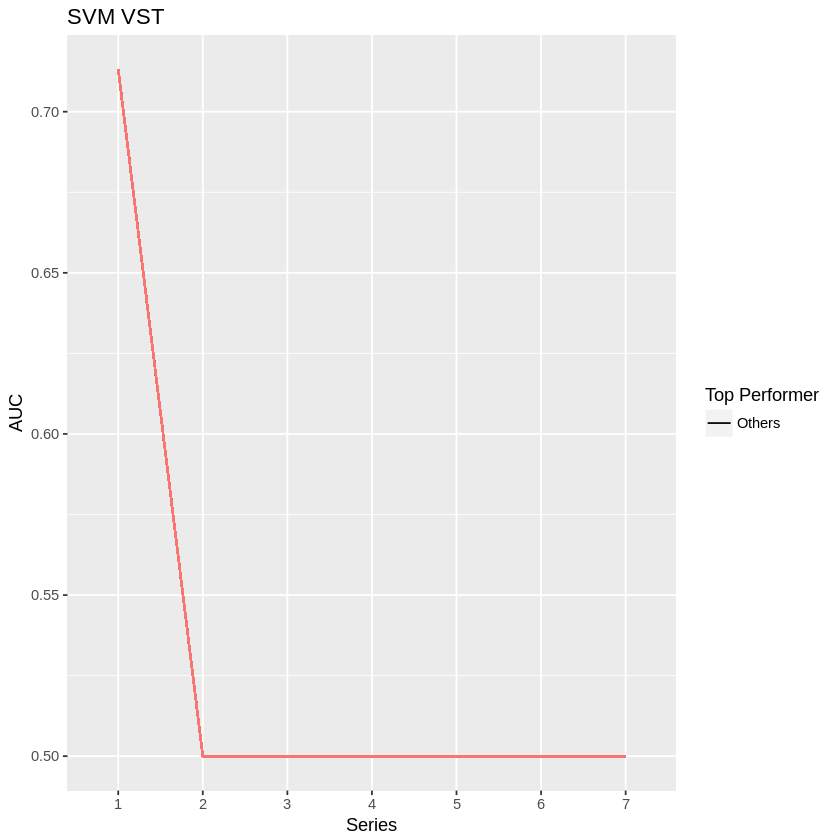

In [36]:
gt <- ggplot_gtable(ggplot_build(ggsvm))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

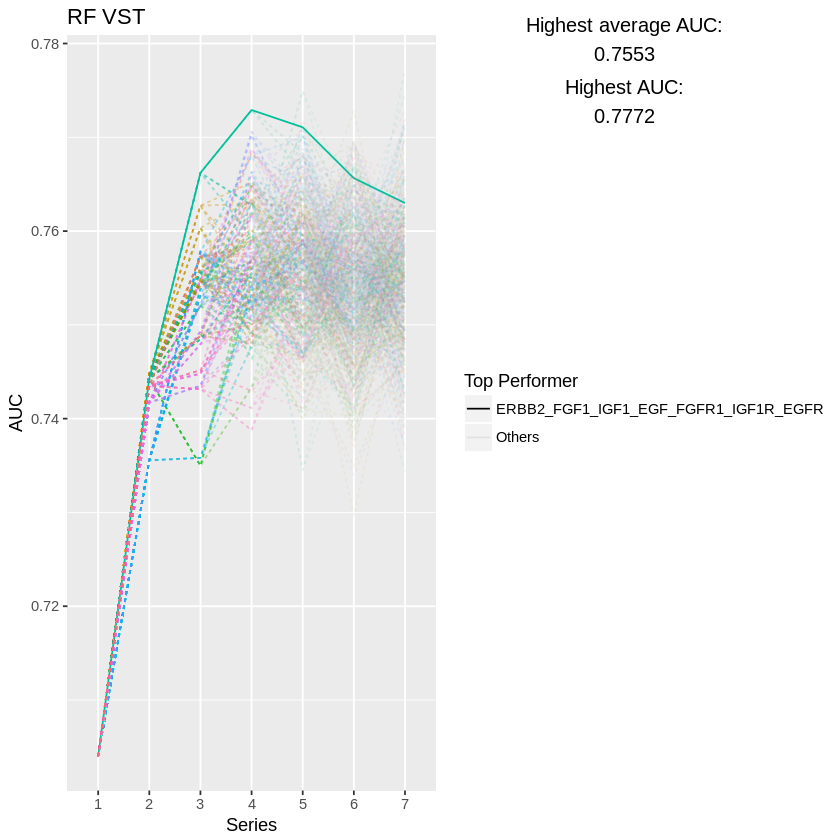

In [37]:
gt <- ggplot_gtable(ggplot_build(ggrf))
gt$layout$clip[gt$layout$name == "panel"] <- "off"
grid.draw(gt)

series,value,genes,relative
1,0.7131158,ERBB2,NaN


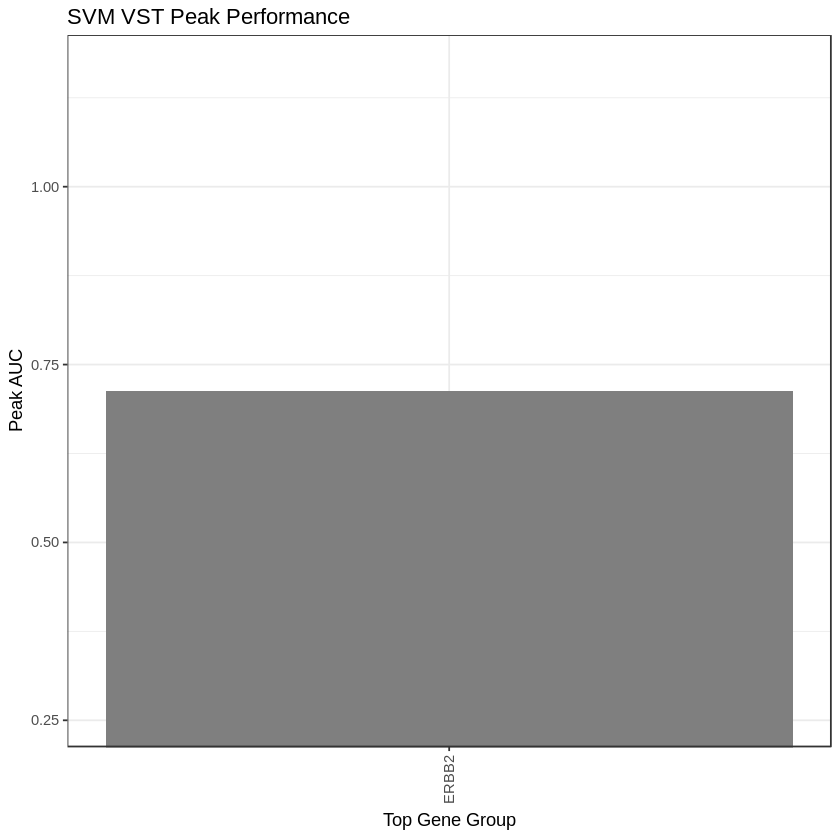

In [38]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- svm.results[which(svm.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "SVM VST Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

#ggsave('peak_performance[error].pdf', gghist, device = 'pdf')

At first I was a little shocked by the above results, but then I remembered that SVM performs worse after the initial ERBB2 testing every time with the standard scaling method

,series,value,genes,relative
2881,5,0.7590476,"ERBB2, FGFR1, EGFR, IGF1R, FGF1",0.3401311
2883,5,0.7578522,"ERBB2, FGFR1, EGFR, IGF1R, EGF",0.2967598
4325,7,0.7589363,"ERBB2, FGFR1, EGFR, IGF1R, IGF1, FGF1, EGF",0.3360903
3606,6,0.7629787,"ERBB2, FGFR1, EGFR, IGF1R, IGF1, EGF",0.4827523
4327,7,0.7550659,"ERBB2, FGFR1, EGFR, FGF1, IGF1R, EGF, IGF1",0.1956692
3608,6,0.7573848,"ERBB2, FGFR1, EGFR, FGF1, IGF1R, IGF1",0.2798021


Saving 30 x 6.67 in image


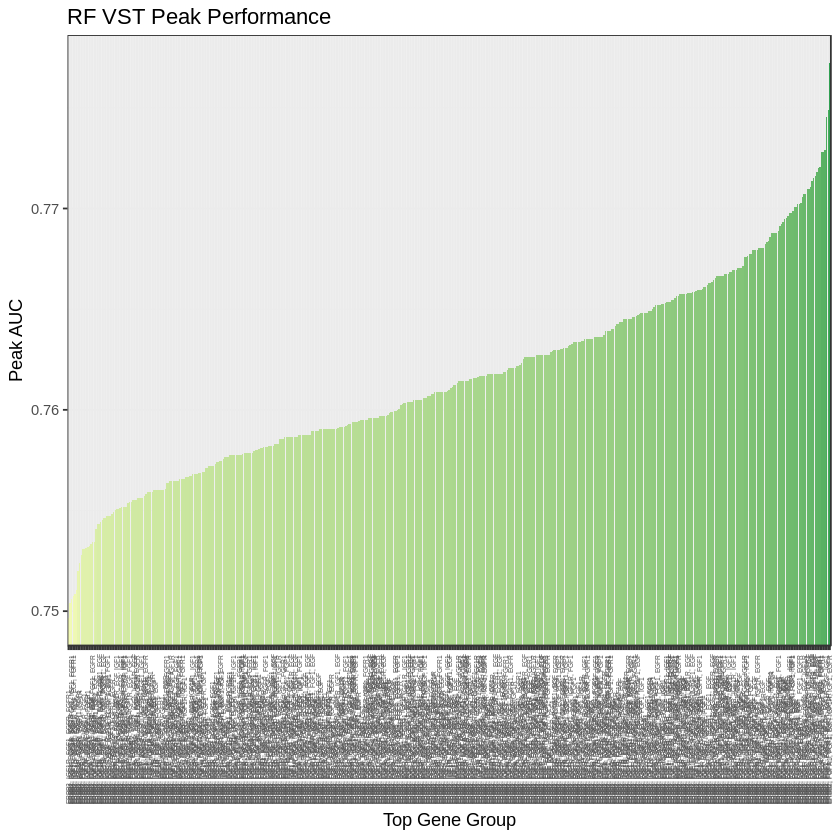

In [39]:
peak.vals <- data.frame(grouping = character(),
                       genes = character(),
                       series = factor(),
                       value = numeric())

# Get the peaks of each grouping and the genes included
for (grouping in groupings){
    temp.df <- rf.results[which(rf.results$grouping == grouping),]
    max.val <- temp.df[which.max(temp.df$value), c('grouping', 'series', 'value')]
    max.val$genes <- paste(unlist(strsplit(grouping, '_'))[1:max(as.numeric(max.val$series))], sep = '', collapse = ', ')
    peak.vals <- rbind(peak.vals, max.val)
    
}
peak.vals <- unique(peak.vals[, c('series', 'value', 'genes')])
peak.vals$genes <- factor(peak.vals$genes, levels = peak.vals$genes[order(peak.vals$value)])

peak.vals$relative <- norm_scale(peak.vals$value)
head(peak.vals)

ghist <- ggplot(peak.vals, aes(x = genes, y = peak.vals$value, fill = relative))
gghist <- ghist + geom_bar(stat = 'identity') + theme_bw() + 
                  labs(title = "RF VST Peak Performance", x = "Top Gene Group", y = "Peak AUC") +
                  guides(fill = F) +
                  ylim(0, 1) +
                  scale_fill_gradient(low = '#f7fcb9', high = '#31a354') +
                  theme(axis.text.x = element_text(angle = 90, size = 4, vjust = 0.5, hjust = 0)) +
                  coord_cartesian(ylim = c(min(peak.vals$value), max(peak.vals$value)))

gghist

ggsave('peak_performance_vst.pdf', gghist, device = 'pdf', width = 30)

>__DOWNLOAD:__ [here](https://github.com/zence/SCCR/raw/Kumiko/notebooks/peak_performance_vst.pdf)

Again, we see that this method has caused SVM to fail after being trained on more than just ERBB2. RF performed decently, but did not outperform RF on Quantile Normalized data.

# Conclusions

## SVM

The Robust Scaler proved to the best method for scaling data when attempting to predict her2 positivity with SVM. Within this, we saw that SVM has poorer performance the noisier the data, meaning that it seems that the less data the better.

Since each graph showed convergence on the seventh series, it would be reasonable for us to infer that the order of the data does not matter to SVM.

We also see that the SVM algorithm is very sensitive to data that is not scaled to its '*liking*'

## RF

BioConductor's Quantile Normalization showed the greatest improvement when used with RF. All other scaling methods showed decent performance and in most of our cases showed that with this particular dataset and classification, RandomForest outperformed SVM. Random Forest shows better performance when given multiple features, but this does not mean that Random Forest will perform amazingly given more data, as the order of the given data seems to affect how the decision tree is made. As stated earlier, we can infer this by the fact that the lines do not converge on the seventh seried, even though the only difference in the data was the order of the columns (genes).